In [1]:
# default_exp score

# Score

> Functions related to the score

This notebook contains all functions related to the scoring of peptide-spectrum-matches (PSMS).

In brief, this notebook includes the following:

- Functions for target-decoy based FDR estimation
- X!tandem based scoring of PSMs
- Machine learning based scoring of PSMs
- Protein grouping by the razor approach

## Filtering

The filtering functions are essential base functions for scoring in AlphaPept. They make sure that only the 'best precursor per spectum' and the 'best spectrum per precursor' is used.

Recall from the search that when having feautres, `raw_idx` refers to the actual index from the raw data. Otherwise it is`query_data`.

For filtering, we have several functions. When applying for a score, we first use `filter_score` and then `filter_precursor`.
`filter_score` is keeping the best score per experimental spectrum. First we rank by score for each `query_idx`. As we have multiple hits for each experimental spectrum from the search we only want to keep the best one.

When performing feature finding, we assign multiple possible features to each experimental spectrum. The idea here is that a spectrum could originate from various precursors. To disentangle these psms we can use the following modes:

* `single`: This mode will only keep one feature per experimental spectrum (the one with the highest score and the closest distance). Each feature can only occur once.
* `multiple`: Allow multiple features per experimental spectrum. Each feature can only occur once.

`filter_precursor` is intended for the case that a precursor (charge + sequence) occurs more than once. Only the one with the highest score will be kept.

In [2]:
#export
import numpy as np
import pandas as pd
import logging
import alphapept.io

def filter_score(df: pd.DataFrame, mode: str='multiple') -> pd.DataFrame:
    """
    Filter psms feature table by keeping only the best scoring psm per experimental spectrum.
    
    TODO: psms could still have the same score when having modifications at multiple positions that are not distinguishable.
    Only keep one.

    Args:
        df (pd.DataFrame): psms table of search results from alphapept.
        mode (str, optional): string specifying which mode to use for psms filtering. The two options are 'single' and 'multiple'. 'single' will only keep one feature per experimental spectrum. 'multiple' will allow multiple features per experimental spectrum. In either option, each feature can only occur once. Defaults to 'multiple'.
        
    Returns:
        pd.DataFrame: table containing the filtered psms results.
    """
    
    if "localexp" in df.columns:
        additional_group = ['localexp']
    else:
        additional_group = []
    
    df["rank"] = df.groupby(["query_idx"] + additional_group)["score"].rank("dense", ascending=False).astype("int")
    df = df[df["rank"] == 1]

    # in case two hits have the same score and therfore the same rank only accept the first one
    df = df.drop_duplicates(["query_idx"] + additional_group)

    if 'dist' in df.columns:
        df["feature_rank"] = df.groupby(["feature_idx"] + additional_group)["dist"].rank("dense", ascending=True).astype("int")
        df["raw_rank"] = df.groupby(["raw_idx"] + additional_group)["score"].rank("dense", ascending=False).astype("int")
        
        if mode == 'single':
            df_filtered = df[(df["feature_rank"] == 1) & (df["raw_rank"] == 1) ]
            df_filtered = df_filtered.drop_duplicates(["raw_idx"] + additional_group)

        elif mode == 'multiple':
            df_filtered = df[(df["feature_rank"] == 1)]

        else:
            raise NotImplementedError('Mode {} not implemented yet'.format(mode))

    else:
        df_filtered = df

    # TOD: this needs to be sorted out, for modifications -> What if we have MoxM -> oxMM, this will screw up with the filter sequence part
    return df_filtered

In [3]:
#hide
def test_filter_score():
    ## DataFrame with unique assignments
    df = pd.DataFrame({'query_idx':[1,1,2,2,3,3], 'score':[1,2,3,4,5,6],'feature_idx':[1,1,1,3,4,5],'raw_idx':[1,1,2,2,3,3]})
    assert len(filter_score(df)) == 3

    ## Spectra competing for a feature, only keep one
    df = pd.DataFrame({'query_idx':[1,2], 'score':[1,2],'feature_idx':[1,1],'raw_idx':[1,2], 'dist':[1,2]})
    assert len(filter_score(df) == 1)

    ## Same spectra multiple features
    df = pd.DataFrame({'query_idx':[1,2], 'score':[1,2],'feature_idx':[1,2],'raw_idx':[1,1], 'dist':[1,2]})
    assert len(filter_score(df, mode='single')) == 1
    assert len(filter_score(df, mode='multiple')) == 2

test_filter_score()

In [4]:
#export

def filter_precursor(df: pd.DataFrame) -> pd.DataFrame:
    """
    Filter psms feature table by precursor.
    Allow each precursor only once.
    
    Args:
        df (pd.DataFrame): psms table of search results from alphapept.
               
    Returns:
        pd.DataFrame: table containing the filtered psms results.

    """
    if "localexp" in df.columns:
        additional_group = ['localexp']
    else:
        additional_group = []
        
    df["rank_precursor"] = (
        df.groupby(["precursor"] + additional_group)["score"].rank("dense", ascending=False).astype("int")
    )
    
    df_filtered = df[df["rank_precursor"] == 1]
    
    if 'int_sum' in df_filtered.columns:
        #if int_sum from feature finding is present: Remove duplicates in case there are any
        df_filtered = df_filtered.sort_values('int_sum')[::-1]
        df_filtered = df_filtered.drop_duplicates(["precursor", "rank_precursor"] + additional_group)

    return df_filtered

In [5]:
#hide

def test_filter_precursor():
    df = pd.DataFrame({'precursor':['A','A','A'],'score':[1,2,3]})
    assert len(filter_precursor(df)) == 1
    df = pd.DataFrame({'precursor':['A','A','B'],'score':[1,2,3]})
    assert len(filter_precursor(df)) == 2
    df = pd.DataFrame({'precursor':['A','B','C'],'score':[1,2,3]})
    assert len(filter_precursor(df)) == 3

test_filter_precursor()

## Q-Values


`get_q_values` is used to calculate q-values from FDR values. The direct relationship is illustrated further down in the notebook. 

In [6]:
#export
from numba import njit
@njit
def get_q_values(fdr_values: np.ndarray) -> np.ndarray:
    """
    Calculate q-values from fdr_values.
    
    Args:
        fdr_values (np.ndarray): np.ndarray of fdr values.

    Returns:
        np.ndarray: np.ndarray of q-values.
    """
    q_values = np.zeros_like(fdr_values)
    min_q_value = np.max(fdr_values)
    for i in range(len(fdr_values) - 1, -1, -1):
        fdr = fdr_values[i]
        if fdr < min_q_value:
            min_q_value = fdr
        q_values[i] = min_q_value

    return q_values

In [7]:
#hide
def test_get_q_values():
    assert np.allclose(get_q_values(np.array([1,2,3,4])), np.array([1,2,3,4]))
    assert np.allclose(get_q_values(np.array([3,3,3,3])), np.array([3,3,3,3]))
    assert np.allclose(get_q_values(np.array([4,3,2,1])), np.array([1,1,1,1]))
    
test_get_q_values()

## FDR

The employed FDR strategy is based on a classical target-decoy competition approach. The procedure works as follows:
1. Consider only the best scoring target or decoy PSM per spectrum. 
2. Sort all PSMs by decreasing scores.
3. Estimate the FDR as #decoys / #targets, where #targets (#decoys) is the number of positive target (decoy) PSMs at a given score threshold t (i.e. PSMs with scores higher than t).
4. Convert the estimated FDR to q-values by selecting the minimum FDR at which the identification could be made, i.e. the lowest score threshold t that could be set to include an identification without increasing the number of false positives.
5. Report the set of target PSMs with q-values smaller or equal to the selected `fdr_level`.

Informative literature describing and discussing different FDR estimation approaches for shotgun proteomics can be found here (the implemented strategy in alphapept is referred to as T-TDC in this article):
> Keich, Uri et al. "Improved False Discovery Rate Estimation Procedure for Shotgun Proteomics." Journal of proteome research vol. 14,8 (2015): 3148-61. <https://pubs.acs.org/doi/10.1021/acs.jproteome.5b00081>


In [8]:
#export
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Note that the test function for cut_fdr is further down in the notebook to also test protein-level FDR.
def cut_fdr(df: pd.DataFrame, fdr_level:float=0.01, plot:bool=True) -> (float, pd.DataFrame):
    """
    Cuts a dataframe with a given fdr level

    Args:
        df (pd.DataFrame): psms table of search results from alphapept.
        fdr_level (float, optional): fdr level that should be used for filtering. The value should lie between 0 and 1. Defaults to 0.01.
        plot (bool, optional): flag to enable plot. Defaults to 'True'.

    Returns:
        float: numerical value of the applied score cutoff
        pd.DataFrame: df with psms within fdr

    """

    df["target"] = ~df["decoy"]

    df = df.sort_values(by=["score","decoy"], ascending=False)
    df = df.reset_index()

    df["target_cum"] = np.cumsum(df["target"])
    df["decoys_cum"] = np.cumsum(df["decoy"])

    df["fdr"] = df["decoys_cum"] / df["target_cum"]
    df["q_value"] = get_q_values(df["fdr"].values)

    last_q_value = df["q_value"].iloc[-1]
    first_q_value = df["q_value"].iloc[0]

    if last_q_value <= fdr_level:
        logging.info('Last q_value {:.3f} of dataset is smaller than fdr_level {:.3f}'.format(last_q_value, fdr_level))
        cutoff_index = len(df)-1

    elif first_q_value >= fdr_level:
        logging.info('First q_value {:.3f} of dataset is larger than fdr_level {:.3f}'.format(last_q_value, fdr_level))
        cutoff_index = 0

    else:
        cutoff_index = df[df["q_value"].gt(fdr_level)].index[0] - 1

    cutoff_value = df.loc[cutoff_index]["score"]
    cutoff = df[df["score"] >= cutoff_value]

    targets = df.loc[cutoff_index, "target_cum"]
    decoy = df.loc[cutoff_index, "decoys_cum"]

    fdr = df.loc[cutoff_index, "fdr"]

    
    logging.info(f"{targets:,} target ({decoy:,} decoy) of {len(df)} PSMs. fdr {fdr:.6f} for a cutoff of {cutoff_value:.2f} (set fdr was {fdr_level})")

    if plot:
        import matplotlib.pyplot as plt
        plt.figure(figsize=(10, 5))
        plt.plot(df["score"], df["fdr"])
        plt.axhline(0.01, color="k", linestyle="--")

        plt.axvline(cutoff_value, color="r", linestyle="--")
        plt.title("fdr vs Cutoff value")
        plt.xlabel("Score")
        plt.ylabel("fdr")
        # plt.savefig('fdr.png')
        plt.show()

        bins = np.linspace(np.min(df["score"]), np.max(df["score"]), 100)
        plt.figure(figsize=(10, 5))
        plt.hist(df[df["decoy"]]["score"].values, label="decoy", bins=bins, alpha=0.5)
        plt.hist(df[~df["decoy"]]["score"].values, label="target", bins=bins, alpha=0.5)
        plt.xlabel("Score")
        plt.ylabel("Frequency")
        plt.title("Score vs Class")
        plt.legend()
        plt.show()

    cutoff = cutoff.reset_index(drop=True)
    return cutoff_value, cutoff

Note that the test function for cut_fdr is further down in the notebook to also test protein-level FDR.

In [9]:
#hide
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Helper functions to create in-silico data.
def simulateTargetDecoyScores(n, target_mu=4.0, stdev=1.0, pi0=0.5):
    decoys = np.random.normal(loc=0.0, scale=stdev, size=n)
    false_targets = np.random.normal(loc=0.0, scale=stdev, size=int(np.round(n*pi0)))
    true_targets = np.random.normal(loc=target_mu, scale=stdev, size=int(np.round(n*(1-pi0))))
    
    df = pd.DataFrame({
        'TD':np.append(np.append(np.repeat('TT',len(true_targets)),np.repeat('FT',len(false_targets))),np.repeat('D',len(decoys))),
        'decoy':np.append(np.repeat(False,len(true_targets)+len(false_targets)), np.repeat(True,len(decoys))),
        'score':np.append(np.append(true_targets,false_targets),decoys),
        'sequence':np.append(np.arange(0,n),np.arange(0,n)),
        'protein':np.append(np.arange(0,n),np.arange(0,n))})
    
    return df

def simulateProteinLevelTargetDecoyScores(n, target_mu=4.0, stdev=1.0, pi0=0.5, plot=True):
    idx = np.arange(0,n)

    protein_size = np.random.poisson(lam=3.0, size=n) + 1
    
    if plot:
        plt.hist(protein_size)
        plt.title("Number of peptides per protein")
        plt.xlabel("Number of peptides per protein")
        plt.ylabel("Count")
        plt.show()

    TT_protein_size = protein_size[idx[0:int(np.round(1-(n*pi0)))]]
    FT_protein_size = protein_size[idx[int(np.round(1-(n*pi0))):n]]
    D_protein_size = protein_size

    true_targets = np.random.normal(loc=target_mu, scale=stdev, size=sum(TT_protein_size))
    false_targets = np.random.normal(loc=0.0, scale=stdev, size=sum(FT_protein_size))
    decoys = np.random.normal(loc=0.0, scale=stdev, size=sum(D_protein_size))

    D_proteins = np.repeat(idx,D_protein_size)
    TT_proteins = np.repeat(idx[0:int(np.round(1-(n*pi0)))],TT_protein_size)
    FT_proteins = np.repeat(idx[int(np.round(1-(n*pi0))):n],FT_protein_size)

    df = pd.DataFrame({
        'TD':np.append(np.append(np.repeat('TT',len(TT_proteins)),np.repeat('FT',len(FT_proteins))),np.repeat('D',len(D_proteins))),
        'decoy':np.append(np.repeat(False,len(TT_proteins)+len(FT_proteins)), np.repeat(True,len(D_proteins))),
        'score':np.append(np.append(true_targets,false_targets),decoys),
        'sequence':np.append(np.arange(0,sum(protein_size)),np.arange(0,sum(protein_size))),
        'protein':np.append(np.append(TT_proteins,FT_proteins),D_proteins)})

    return df

def plot_score_hist(df, analyte_level='sequence'):
    
    if analyte_level=='protein':
        df = df.sort_values(by=['protein','score'], ascending=False)
        df = df.drop_duplicates(subset='protein', keep="first")
    
    decoys=df[df.decoy].score.values
    false_targets= df[df.TD == 'FT'].score.values
    true_targets= df[df.TD == 'TT'].score.values
    
    minS = int(np.round(np.min(np.append(decoys, np.append(false_targets, true_targets)))))
    maxS = int(np.round(np.max(np.append(decoys, np.append(false_targets, true_targets)))))
    
    plt.hist(false_targets, rwidth=.4, bins=range(minS,maxS), range=[minS,maxS], align='mid', label='false targets')
    plt.hist(true_targets, rwidth=.4, bins=range(minS,maxS), range=[minS,maxS], align='mid', label='true targets')
    plt.hist(decoys, rwidth=.4, bins=range(minS,maxS), range=[minS,maxS], align='left', label='decoys')
    plt.legend(loc='best')
    plt.title("score histogram")
    plt.xlabel("score")
    plt.ylabel("count")
    plt.xlim(-5,10)
    plt.show()

def score_TDcompetition(df):
    td_dataframe = pd.DataFrame({'T':df[~df.decoy].score.values, 'D':df[df.decoy].score.values, 'label':df[~df.decoy].TD.values})
    td_dataframe['win'] = td_dataframe.apply(lambda x: 'T' if x['T'] > x['D'] else 'D', axis = 1)

    target_in = np.where(td_dataframe.win=='T')
    decoy_in = np.where(td_dataframe.win=='D')

    T_df = df[(~df.decoy) & (np.isin(df.sequence, target_in))]
    D_df = df[(df.decoy) & (np.isin(df.sequence, decoy_in))]
    
    df = T_df.append(D_df)
    
    return df


def get_simulated_stat_rates(df, TDcompetition = False, analyte_level='sequence', df_ini = None):
    alpha = np.arange(0.002,1,0.002)
    stat_rates = pd.DataFrame(columns=['alpha','TP','FP','TN','FN','TPR','FPR','FDR','FNR','ACC'])

    if analyte_level=='protein':
        df = df.drop_duplicates(subset='protein', keep="first")
        
    for idx in range(len(alpha)):
        sig = df[df.q_value <= alpha[idx]]
        not_sig = df[df.q_value > alpha[idx]]

        TP = len(sig[sig.TD == 'TT'][analyte_level].unique())
        FP = len(sig[sig.TD == 'FT'][analyte_level].unique())
        TN = len(not_sig[not_sig.TD == 'FT'][analyte_level].unique())
        FN = len(not_sig[not_sig.TD == 'TT'][analyte_level].unique())
        
        if TDcompetition:
            TN = TN + (len(df_ini[df_ini.TD == 'FT'][analyte_level].unique()) - len(df[df.TD == 'FT'][analyte_level].unique()))
            FN = FN + (len(df_ini[df_ini.TD == 'TT'][analyte_level].unique()) - len(df[df.TD == 'TT'][analyte_level].unique()))


        TPR = TP/(TP+FN) 
        FPR = FP/(FP+TN) 
        if (FP+TP)==0:
            FDR = 0
        else:
            FDR = FP/(FP+TP)
        FNR = FN/(FN+TP)

        ACC = (TP+TN)/(TP+TN+FP+FN)

        stat_rates.loc[idx] = [alpha[idx], TP, FP, TN, FN, TPR, FPR, FDR, FNR, ACC] 
    
    border = 0.1
    
    plt.plot([-1,2], [-1,2], linestyle="--", color='red')
    plt.scatter(stat_rates.alpha, stat_rates.FDR)
    plt.ylim(0-border,1+border)
    plt.xlim(0-border,1+border)
    plt.title("decoy vs. true FDR")
    plt.xlabel("decoy FDR")
    plt.ylabel("true FDR")
    plt.show()
    
    plt.plot([-1,1], [-1,1], linestyle="--", color='red')
    plt.scatter(stat_rates.alpha, stat_rates.FDR)
    plt.ylim(0-(0.01),0.1+(0.01))
    plt.xlim(0-(0.01),0.1+(0.01))
    plt.title("decoy vs. true FDR (zoom)")
    plt.xlabel("decoy FDR")
    plt.ylabel("true FDR")
    plt.show()
    
    plt.plot([-1,2], [1,1], linestyle="--", color='red')
    plt.scatter(stat_rates.FPR, stat_rates.TPR)
    plt.ylim(0-border,1+border)
    plt.xlim(0-border,1+border)
    plt.title("ROC curve")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.show()
    
    plt.plot([-1,2], [1,1], linestyle="--", color='red')
    plt.scatter(stat_rates.FPR, stat_rates.TPR)
    plt.ylim(0-border,1+border)
    plt.xlim(0-0.01,0.1+0.01)
    plt.title("ROC curve (zoom)")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.show()
    
    return stat_rates

def plot_qvalue_vs_fdr(df):
    plt.plot(df.fdr, df.target_cum, label='FDR')
    plt.plot(df.q_value, df.target_cum, label='q-value')
    plt.xlim(0-0.0001,0.005)
    plt.ylim(0-100,7000)
    plt.legend(loc='best')
    plt.title("Difference between q-value and FDR")
    plt.xlabel("q-value / FDR")
    plt.ylabel("Cummulative number of accepted targets")
    plt.show()

In [10]:
#hide
TD = simulateTargetDecoyScores(n=50000, pi0=0.8, target_mu=3.5)
TDC = score_TDcompetition(TD)

Simulation of random scores for 50'000 measurements (corresponding to spectra). Simulated are decoys, true targets and false targets. We assume a false traget raio (pi0) of 0.8 and a mean score difference of 3.5.

Simulated score distribution for a separate target and decoy database search:

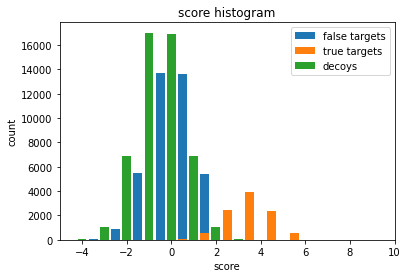

In [11]:
#hide
plot_score_hist(TD, analyte_level='sequence')

Simulated score distribution for a corresponding concatinated target-decoy database search with target-decoy-competition:

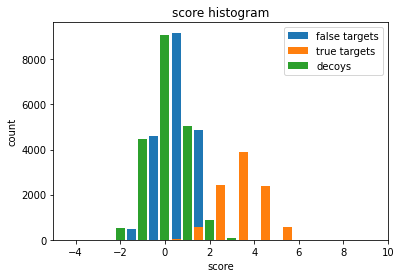

In [12]:
#hide
plot_score_hist(TDC, analyte_level='sequence')

Application of the `cut_fdr` function to the simulated target-decoy competition dataset saved in `TDC`:

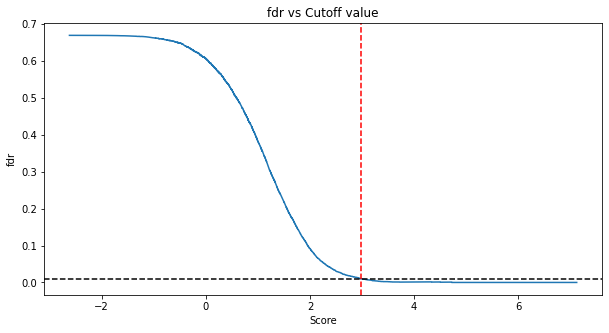

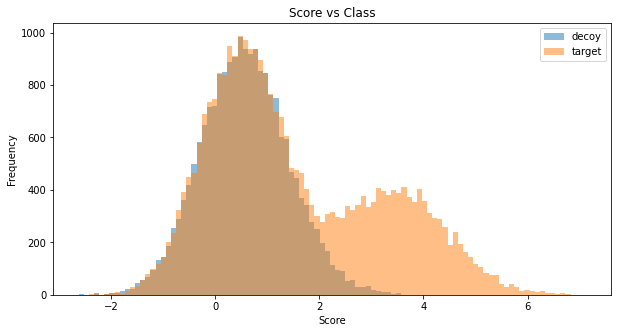

In [13]:
cval, cut_TDC = cut_fdr(TDC, fdr_level=0.01)

Evaluation of the FDR estimated by the target-decoy approach versus the true FDR confirms accurate FDR estimation by our approach. The true FDR is capped by the selected fraction of false targets (pi0 = 0.8) and by the effect of target decoy competition. Similarly, the true positive rate (TPR) is limited by the effect of target decoy competition and can only reach 1 in cases where not a single decoy scores higher than a true target.

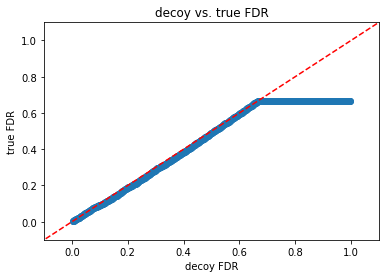

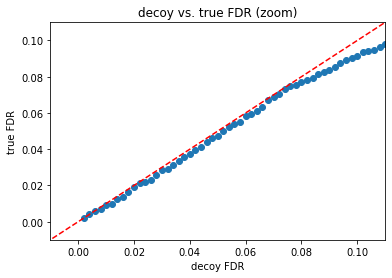

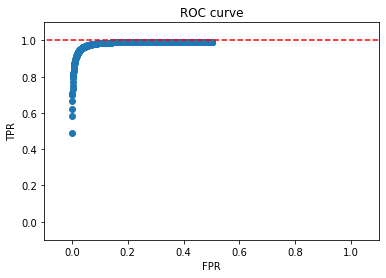

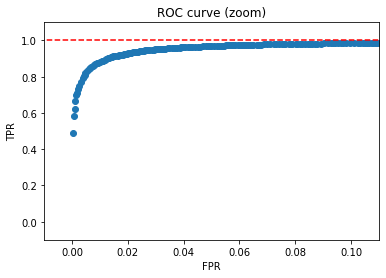

In [14]:
# hide
cval_, cut_TDC_ = cut_fdr(TDC, fdr_level=100, plot=False)
stat = get_simulated_stat_rates(cut_TDC_, TDcompetition = True, analyte_level='sequence', df_ini = TD)

The following figure illustrates the difference between `fdr` and `q_value`.

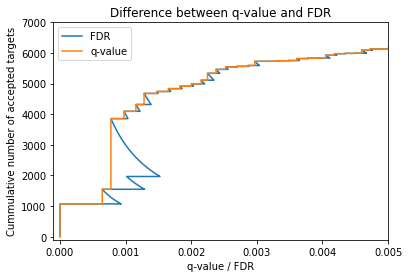

In [15]:
# hide
plot_qvalue_vs_fdr(cut_TDC_)

Please be aware that the shown simulations are not an accurate model for PSMS scoring and they were designed only for illustrative purposes and to test the implemeted functions. 

## Global FDR

The `cut_global_fdr` function has two specific applications:
1. **Estimate q-values on the peptide and protein level** <br/>
The concept here is based on selecting the best scoring precursor per peptide (or protein) to then estimate the FDR by target-decoy competition using the `cut_fdr` function.
2. **Estimate q-values across an entire dataset on either precursor, peptide or protein level** <br/>
The concept here is based on selecting the best scoring precursor, peptide or protein signal across an entire dataset to then estimate the FDR by target-decoy competition using the `cut_fdr` function.

This strategy was extensively tested and discussed in the following publications:

* Nesvizhskii, Alexey I. "A survey of computational methods and error rate estimation procedures for peptide and protein identification in shotgun proteomics." Journal of proteomics vol. 73,11 (2010): 2092-123. <https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2956504/> 

* Savitski, Mikhail M et al. "A Scalable Approach for Protein False Discovery Rate Estimation in Large Proteomic Data Sets." Molecular & cellular proteomics : MCP vol. 14,9 (2015): 2394-404. <https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4563723/>

* The, Matthew et al. "Fast and Accurate Protein False Discovery Rates on Large-Scale Proteomics Data Sets with Percolator 3.0." Journal of the American Society for Mass Spectrometry vol. 27,11 (2016): 1719-1727. <https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5059416/>

* Gupta, Nitin, and Pavel A Pevzner. "False discovery rates of protein identifications: a strike against the two-peptide rule." Journal of proteome research vol. 8,9 (2009): 4173-81. 
<https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3398614/>

In [16]:
#export

def cut_global_fdr(data: pd.DataFrame, analyte_level: str='sequence', fdr_level: float=0.01, plot: bool=True, **kwargs) -> pd.DataFrame:
    """
    Function to estimate and filter by global peptide or protein fdr
    
    Args:
        data (pd.DataFrame): psms table of search results from alphapept.
        analyte_level (str, optional): string specifying the analyte level to apply the fdr threshold. Options include: 'precursor', 'sequence', 'protein_group' and 'protein'. Defaults to 'sequence'.
        fdr_level (float, optional): fdr level that should be used for filtering. The value should lie between 0 and 1. Defaults to 0.01.
        plot (bool, optional): flag to enable plot. Defaults to 'True'.

    Returns:
        pd.DataFrame: df with filtered results

    """
    logging.info('Global FDR on {}'.format(analyte_level))
    data_sub = data[[analyte_level,'score','decoy']]
    data_sub_unique = data_sub.groupby([analyte_level,'decoy'], as_index=False).agg({"score": "max"})

    analyte_levels = ['precursor', 'sequence', 'protein_group','protein']

    if analyte_level in analyte_levels:
        agg_score = data_sub_unique.groupby([analyte_level,'decoy'])['score'].max().reset_index()
    else:
        raise Exception('analyte_level should be either sequence or protein. The selected analyte_level was: {}'.format(analyte_level))

    agg_cval, agg_cutoff = cut_fdr(agg_score, fdr_level=fdr_level, plot=plot)

    agg_report = data.reset_index().merge(
                        agg_cutoff,
                        how = 'inner',
                        on = [analyte_level,'decoy'],
                        suffixes=('', '_'+analyte_level),
                        validate="many_to_one").set_index('index') #retain the original index
    return agg_report

Similar to the sequence level simulations we can simulatae score distributions for peptides beloning to proteins. In our simulation we assumed a poisson distribution for the number of peptides for each protein centered at 4 peptides. 

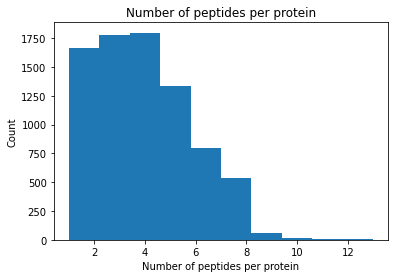

In [17]:
#hide
TD_prot = simulateProteinLevelTargetDecoyScores(n=8000, pi0=0.8, target_mu=3.5)

TDC_prot = score_TDcompetition(TD_prot)


Application of the `cut_global_fdr` function to the simulated protein-level target-decoy competition dataset saved in `TDC_prot`:

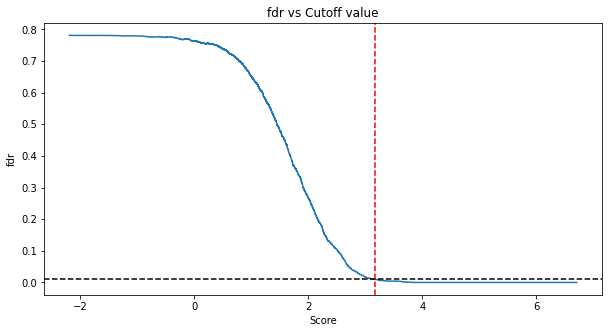

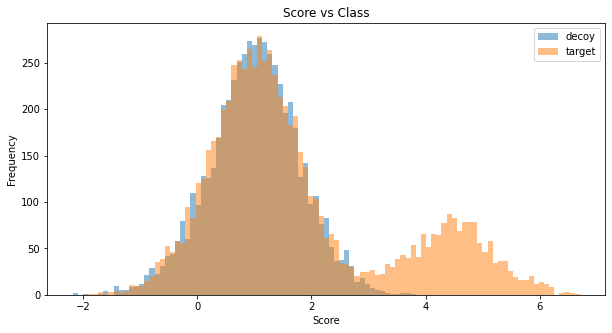

In [18]:
cut_TDC_prot = cut_global_fdr(TDC_prot, fdr_level=0.01, analyte_level='protein')

Evaluation of the protein-level FDR estimated by the target-decoy approach versus the true FDR confirms accurate FDR estimation by our approach:

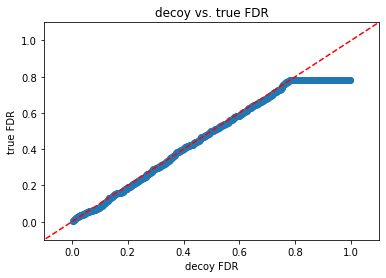

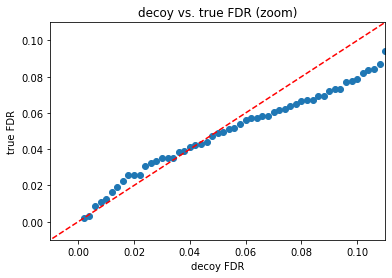

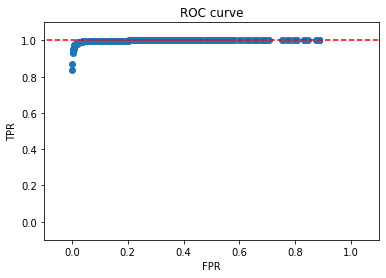

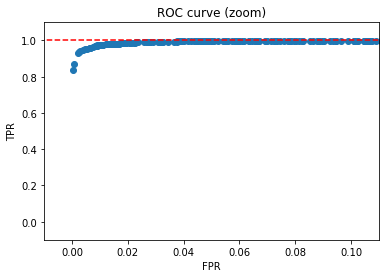

In [19]:
#hide
cut_TDC_prot_ = cut_global_fdr(TDC_prot, fdr_level=100, analyte_level='protein', plot=False)
stat_prot = get_simulated_stat_rates(cut_TDC_prot_, TDcompetition = True, analyte_level='protein', df_ini = TD_prot)

Investigating the peptide-level statistics after protein-level FDR filtering shows a conservative pattern.

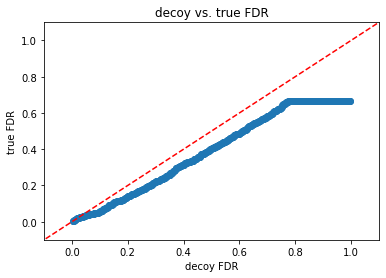

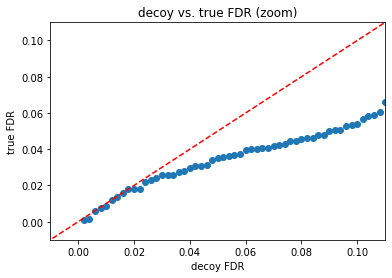

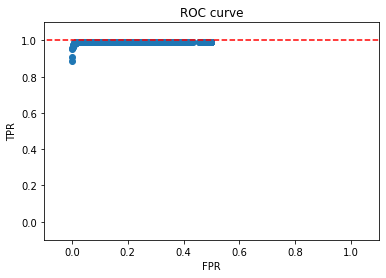

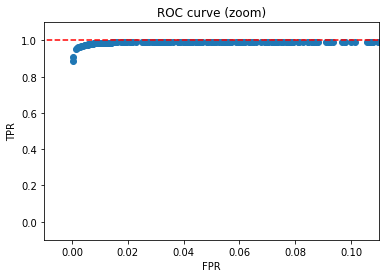

In [20]:
#hide
stat_prot = get_simulated_stat_rates(cut_TDC_prot_, TDcompetition = True, analyte_level='sequence', df_ini = TD_prot)

Please be aware that the shown simulations are not an accurate model for PSMS scoring and they were designed only for illustrative purposes and to test the implemeted functions. 

## Scoring

### X!tandem scoring

* `get_x_tandem_score` performs scoring of PSMs according to the X!tandem strategy:

* `score_x_tandem` first calls `get_x_tandem_score` and and subsequently applies the `cut_fdr` function to filter PSMs at the specified `fdr_level`.

> X!Tandem, Craig,R. and Beavis,R.C. (2003) Rapid Commun. Mass Spectrom., 17, 2310-2316

In [21]:
#export

import networkx as nx

def get_x_tandem_score(df: pd.DataFrame) -> np.ndarray:
    """
    Function to calculate the x tandem score
    
    Args:
        df (pd.DataFrame): psms table of search results from alphapept.
        
    Returns:
        np.ndarray: np.ndarray with x_tandem scores

    """
    b = df['b_hits'].astype('int').apply(lambda x: np.math.factorial(x)).values
    y = df['y_hits'].astype('int').apply(lambda x: np.math.factorial(x)).values
    x_tandem = np.log(b.astype('float')*y.astype('float')*df['matched_int'].values)

    x_tandem[x_tandem==-np.inf] = 0

    return x_tandem

def score_x_tandem(df: pd.DataFrame, fdr_level: float = 0.01, plot: bool = True, **kwargs) -> pd.DataFrame:
    """
    Filters the psms table by using the x_tandem score and filtering the results for fdr_level.
    
    Args:
        df (pd.DataFrame): psms table of search results from alphapept.
        fdr_level (float, optional): fdr level that should be used for filtering. The value should lie between 0 and 1. Defaults to 0.01.
        
    Returns:
        pd.DataFrame: psms table with an extra 'score' column for x_tandem, filtered for no feature or precursor to be assigned multiple times.
    """
    logging.info('Scoring using X-Tandem')
    if 'localexp' not in df.columns:
        df['localexp'] = 0
    df['score'] = get_x_tandem_score(df)
    df['decoy'] = df['sequence'].str[-1].str.islower()

    df = filter_score(df)
    df = filter_precursor(df)
    cval, cutoff = cut_fdr(df, fdr_level, plot)

    return cutoff

def filter_with_x_tandem(df: pd.DataFrame) -> pd.DataFrame:
    """
    Filters the psms table by using the x_tandem score, no fdr filter.
    TODO: Remove redundancy with score functions, see issue: #275
    
    Args:
        df (pd.DataFrame): psms table of search results from alphapept.
        
    Returns:
        pd.DataFrame: psms table with an extra 'score' column for x_tandem, filtered for no feature or precursor to be assigned multiple times.
    """
    logging.info('Filter df with x_tandem score')

    df['score'] = get_x_tandem_score(df)
    df['decoy'] = df['sequence'].str[-1].str.islower()

    df = filter_score(df)
    df = filter_precursor(df)

    return df

def filter_with_score(df: pd.DataFrame):
    """
    Filters the psms table by using the score column, no fdr filter.
    TODO: Remove redundancy with score functions, see issue: #275
    
    Args:
        df (pd.DataFrame): psms table of search results from alphapept.
        
    Returns:
        pd.DataFrame: psms table filtered for no feature or precursor to be assigned multiple times.
    """
    logging.info('Filter df with custom score')

    df['decoy'] = df['sequence'].str[-1].str.islower()

    df = filter_score(df)
    df = filter_precursor(df)

    return df

In [22]:
#hide

def test_get_x_tandem_score():
    y_hits = np.array([1,2,3,0])
    b_hits = np.array([0,1,2,1])
    matched_int = np.array([1000,1000,1000,1000])
    df = pd.DataFrame({'y_hits':y_hits,'b_hits':b_hits,'matched_int':matched_int})
    np.testing.assert_almost_equal(get_x_tandem_score(df), np.array([6.90775528, 7.60090246, 9.39266193, 6.90775528]))

test_get_x_tandem_score()

def test_score_x_tandem():
    y_hits = np.array([1,2,3,0])
    b_hits = np.array([0,1,2,1])
    matched_int = np.array([1000,1000,1000,1000])
    sequence = np.array(['A','A','B','C_decoy'])
    precursor = np.array(['A1','A1','B','C_decoy'])
    query_idx = np.array([1,2,3,4])
    df = pd.DataFrame({'y_hits':y_hits,'b_hits':b_hits,'matched_int':matched_int,
                      'sequence':sequence,'precursor':precursor,'query_idx':query_idx})
    res = score_x_tandem(df, fdr_level=1, plot=False)
    assert all(res.precursor == ['B','A1','C_decoy'])
    assert all(res.q_value == [0,0,0.5])

test_score_x_tandem()

### Score and filter PSMs by any specified score

`score_psms` uses the specified `score` and applies the `cut_fdr` function to filter PSMs at the specified `fdr_level`. `filter_score` and `filter_precursor` are applied to only report the best PSM per acquired spectrum and the best signal per precursor (i.e. sequence + charge combination).

In [23]:
#export

def score_psms(df: pd.DataFrame, score: str='y_hits', fdr_level: float=0.01, plot: bool=True, **kwargs) -> pd.DataFrame:
    """
    Uses the specified score in df to filter psms and to apply the fdr_level threshold.

    Args:
        df (pd.DataFrame): psms table of search results from alphapept.
        score (str, optional): string specifying the column in df to use as score. Defaults to 'y_hits'.
        fdr_level (float, optional): fdr level that should be used for filtering. The value should lie between 0 and 1. Defaults to 0.01.
        plot (bool, optional): flag to enable plot. Defaults to 'True'.

    Returns:
        pd.DataFrame: filtered df with psms within fdr

    """
    if score in df.columns:
        df['score'] = df[score]
    else:
        raise ValueError("The specified 'score' {} is not available in 'df'.".format(score))
    df['decoy'] = df['sequence'].str[-1].str.islower()

    df = filter_score(df)
    df = filter_precursor(df)
    cval, cutoff = cut_fdr(df, fdr_level, plot)

    return cutoff

In [24]:
#hide

def test_score_psms():
    y_hits = np.array([1,2,3,0])
    b_hits = np.array([0,1,2,1])
    matched_int = np.array([1000,1000,1000,1000])
    sequence = np.array(['A','A','B','C_decoy'])
    precursor = np.array(['A1','A1','B','C_decoy'])
    query_idx = np.array([1,2,3,4])
    df = pd.DataFrame({'y_hits':y_hits,'b_hits':b_hits,'matched_int':matched_int,
                      'sequence':sequence,'precursor':precursor,'query_idx':query_idx})
    
    res = score_psms(df, fdr_level=1, plot=False)
    assert all(res.precursor == ['B','A1','C_decoy'])
    assert all(res.q_value == [0,0,0.5])
    
    res = score_psms(df, score='b_hits', fdr_level=1, plot=False)
    assert all(res.precursor == ['B','C_decoy','A1'])
    assert all(res.q_value == [0,0.5,0.5])

test_score_x_tandem()

## Machine learning based scoring of PSMs

* `get_ML_features` extracts additional scoring metrics for the machine learning, including the number of amino acids per precursor, the number of missed cleavages and the logarithmic number of times the same peptide occurs in the set of PSMs

* `train_RF` trains a random forest classifier for scoring all PSMs. For this, we use the scikit-learn library.
    * First, a machine learning pipeline is created including the sklearn `StandardScaler` and `RandomForestClassifier`. The `StandardScaler` is used to standardize all features by removing the mean and scaling to unit variance. For details on the `RandomForestClassifier` see: <https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html>.
    * Next, a grid search is initialized for testing the hyperparameter space (`max_depth` and `max_leaf_nodes`) of the random forest classifier by a 5-fold cross-validation using `GridSearchCV`.
    * To train the classifier, we first select a suitable set of PSMSs. This is achieved by an initial scoring and FDR estimation of the input PSMs based on the `ini_score`. Only targets below the `train_fdr_level` cutoff are considered for training the classifier. To ensure a balanced dataset for training (i.e. same number of targets and decoys), the number of PSMs per category is selected to be the minimum of either the number of high scoring targets below the `train_fdr_level` cutoff or the overall number of decoys among the PSMs. `min_train` specifies the minimum number of targets and decoys that should be available. 
    * Once a balanced set of PSMs is established, the PSMs are split into a training and test set accoring to the `test_size` argument using `train_test_split` from sklearn while ensuring the PSMs are split in a stratified fashion (i.e. equal number of targets and decoys in both the training and test sets).
    * The grid search and training of the random forest classifier is performed on the training set of PSMs. The `GridSearchCV` returns the classifier which performed best across all cross-validation hold-out sets according to the `scoring` function (classification *'accuracy'* is set as default score). The grid search is parallelize dinto `n_jobs`.
    * Next, the trained classifier is applied to the testing set of PSMs and the test score is reported. 
    * If `plot` is enabled, a figure illustrating the weights of each feature is produced.
    * Finally the function returns the trained random forest classifier for subsequent application to the entire set of PSMs or for transfering to a different dataset. 

* `score_ML` applies a classifier trained by `train_RF` to a complete set of PSMs. It calls the `cut_fdr` function and filters for the specified `fdr_level`. `filter_score` and `filter_precursor` are applied to only report the best PSM per acquired spectrum and the best signal per precursor (i.e. sequence + charge combination).

In [25]:
#export

import numpy as np
import pandas as pd
import sys

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt

from alphapept.fasta import count_missed_cleavages, count_internal_cleavages


def get_ML_features(df: pd.DataFrame, protease: str='trypsin', **kwargs) -> pd.DataFrame:
    """
    Uses the specified score in df to filter psms and to apply the fdr_level threshold.

    Args:
        df (pd.DataFrame): psms table of search results from alphapept.
        protease (str, optional): string specifying the protease that was used for proteolytic digestion. Defaults to 'trypsin'.

    Returns:
        pd.DataFrame: df including additional scores for subsequent ML. 

    """
    df['decoy'] = df['sequence'].str[-1].str.islower()

    df['abs_delta_m_ppm'] = np.abs(df['delta_m_ppm'])
    df['naked_sequence'] = df['sequence'].apply(lambda x: ''.join([_ for _ in x if _.isupper()]))
    df['n_AA']= df['naked_sequence'].str.len()
    df['matched_ion_fraction'] = df['hits']/(2*df['n_AA'])

    df['n_missed'] = df['naked_sequence'].apply(lambda x: count_missed_cleavages(x, protease))
    df['n_internal'] = df['naked_sequence'].apply(lambda x: count_internal_cleavages(x, protease))
    
    df['x_tandem'] = get_x_tandem_score(df)

    return df

def train_RF(df: pd.DataFrame,
             exclude_features: list = ['precursor_idx','ion_idx','fasta_index','feature_rank','raw_rank','rank','db_idx', 'feature_idx', 'precursor', 'query_idx', 'raw_idx','sequence','decoy','naked_sequence','target'],
             train_fdr_level:  float = 0.1,
             ini_score: str = 'x_tandem',
             min_train: int = 1000,
             test_size: float = 0.8,
             max_depth: list = [5,25,50],
             max_leaf_nodes: list = [150,200,250],
             n_jobs: int = -1,
             scoring: str = 'accuracy',
             plot:bool = False,
             random_state: int = 42,
             **kwargs) -> (GridSearchCV, list):
    
    """
    Function to train a random forest classifier to separate targets from decoys via semi-supervised learning.

    Args:
        df (pd.DataFrame): psms table of search results from alphapept.
        exclude_features (list, optional): list with features to exclude for ML. Defaults to ['precursor_idx','ion_idx','fasta_index','feature_rank','raw_rank','rank','db_idx', 'feature_idx', 'precursor', 'query_idx', 'raw_idx','sequence','decoy','naked_sequence','target'].
        train_fdr_level (float, optional): Only targets below the train_fdr_level cutoff are considered for training the classifier. Defaults to 0.1.
        ini_score (str, optional): Initial score to select psms set for semi-supervised learning. Defaults to 'x_tandem'.
        min_train (int, optional): Minimum number of psms in the training set. Defaults to 1000.
        test_size (float, optional): Fraction of psms used for testing. Defaults to 0.8.
        max_depth (list, optional): List of clf__max_depth parameters to test in the grid search. Defaults to [5,25,50].
        max_leaf_nodes (list, optional): List of clf__max_leaf_nodes parameters to test in the grid search. Defaults to [150,200,250].
        n_jobs (int, optional): Number of jobs to use for parallelizing the gridsearch. Defaults to -1.
        scoring (str, optional): Scoring method for the gridsearch. Defaults to'accuracy'.
        plot (bool, optional): flag to enable plot. Defaults to 'False'.
        random_state (int, optional): Random state for initializing the RandomForestClassifier. Defaults to 42.

    Returns:
        [GridSearchCV, list]: GridSearchCV: GridSearchCV object with trained RandomForestClassifier. list: list of features used for training the classifier.

    """
    
    if getattr(sys, 'frozen', False):
        logging.info('Using frozen pyinstaller version. Setting n_jobs to 1')
        n_jobs = 1
    
    features = [_ for _ in df.columns if _ not in exclude_features]

    # Setup ML pipeline
    scaler = StandardScaler()
    rfc = RandomForestClassifier(random_state=random_state) # class_weight={False:1,True:5},
    ## Initiate scaling + classification pipeline
    pipeline = Pipeline([('scaler', scaler), ('clf', rfc)])
    parameters = {'clf__max_depth':(max_depth), 'clf__max_leaf_nodes': (max_leaf_nodes)}
    ## Setup grid search framework for parameter selection and internal cross validation
    cv = GridSearchCV(pipeline, param_grid=parameters, cv=5, scoring=scoring,
                     verbose=0,return_train_score=True,n_jobs=n_jobs)

    # Prepare target and decoy df
    df['decoy'] = df['sequence'].str[-1].str.islower()
    df['target'] = ~df['decoy']
    df['score'] = df[ini_score]
    dfT = df[~df.decoy]
    dfD = df[df.decoy]

    # Select high scoring targets (<= train_fdr_level)
    df_prescore = filter_score(df)
    df_prescore = filter_precursor(df_prescore)
    scored = cut_fdr(df_prescore, fdr_level = train_fdr_level, plot=False)[1]
    highT = scored[scored.decoy==False]
    dfT_high = dfT[dfT['query_idx'].isin(highT.query_idx)]
    dfT_high = dfT_high[dfT_high['db_idx'].isin(highT.db_idx)]

    # Determine the number of psms for semi-supervised learning
    n_train = int(dfT_high.shape[0])
    if dfD.shape[0] < n_train:
        n_train = int(dfD.shape[0])
        logging.info("The total number of available decoys is lower than the initial set of high scoring targets.")
    if n_train < min_train:
        raise ValueError("There are fewer high scoring targets or decoys than required by 'min_train'.")

    # Subset the targets and decoys datasets to result in a balanced dataset
    df_training = dfT_high.sample(n=n_train, random_state=random_state).append(dfD.sample(n=n_train, random_state=random_state))

    # Select training and test sets
    X = df_training[features]
    y = df_training['target'].astype(int)
    X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=test_size, random_state=random_state, stratify=y.values)

    # Train the classifier on the training set via 5-fold cross-validation and subsequently test on the test set
    logging.info('Training & cross-validation on {} targets and {} decoys'.format(np.sum(y_train),X_train.shape[0]-np.sum(y_train)))
    cv.fit(X_train,y_train)

    logging.info('The best parameters selected by 5-fold cross-validation were {}'.format(cv.best_params_))
    logging.info('The train {} was {}'.format(scoring, cv.score(X_train, y_train)))
    logging.info('Testing on {} targets and {} decoys'.format(np.sum(y_test),X_test.shape[0]-np.sum(y_test)))
    logging.info('The test {} was {}'.format(scoring, cv.score(X_test, y_test)))
    
    feature_importances=cv.best_estimator_.named_steps['clf'].feature_importances_
    indices = np.argsort(feature_importances)[::-1][:40]
    
    top_features = X.columns[indices][:40]
    top_score = feature_importances[indices][:40]
    
    feature_dict = dict(zip(top_features, top_score))
    logging.info(f"Top features {feature_dict}")
    
    # Inspect feature importances
    if plot:
        import seaborn as sns
        g = sns.barplot(y=X.columns[indices][:40],
                        x = feature_importances[indices][:40],
                        orient='h', palette='RdBu')
        g.set_xlabel("Relative importance",fontsize=12)
        g.set_ylabel("Features",fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title("Feature importance")
        plt.show()

    return cv, features

def score_ML(df: pd.DataFrame,
             trained_classifier: GridSearchCV,
             features: list = None,
             fdr_level: float = 0.01,
             plot: bool = True,
             **kwargs) -> pd.DataFrame:
    """
    Applies a trained ML classifier to df and uses the ML score to filter psms and to apply the fdr_level threshold.

    Args:
        df (pd.DataFrame): psms table of search results from alphapept.
        trained_classifier (GridSearchCV): GridSearchCV object returned by train_RF.
        features (list): list with features returned by train_RF. Defaults to 'None'.
        fdr_level (float, optional): fdr level that should be used for filtering. The value should lie between 0 and 1. Defaults to 0.01.
        plot (bool, optional): flag to enable plot. Defaults to 'True'.

    Returns:
        pd.DataFrame: filtered df with psms within fdr

    """
    logging.info('Scoring using Machine Learning')
    # Apply the classifier to the entire dataset
    df_new = df.copy()
    df_new['score'] = trained_classifier.predict_proba(df_new[features])[:,1]
    df_new = filter_score(df_new)
    df_new = filter_precursor(df_new)
    cval, cutoff = cut_fdr(df_new, fdr_level, plot)

    return cutoff


def filter_with_ML(df: pd.DataFrame,
             trained_classifier: GridSearchCV,
             features: list = None,
             **kwargs) -> pd.DataFrame:

    """
    Filters the psms table by using the x_tandem score, no fdr filter.
    TODO: Remove redundancy with score functions, see issue: #275
    
    Args:
        df (pd.DataFrame): psms table of search results from alphapept.
        trained_classifier (GridSearchCV): GridSearchCV object returned by train_RF.
        features (list): list with features returned by train_RF. Defaults to 'None'.
        
    Returns:
        pd.DataFrame: psms table with an extra 'score' column from the trained_classifier by ML, filtered for no feature or precursor to be assigned multiple times.
    """
    logging.info('Filter df with x_tandem score')
    # Apply the classifier to the entire dataset
    df_new = df.copy()
    df_new['score'] = trained_classifier.predict_proba(df_new[features])[:,1]
    df_new = filter_score(df_new)
    df_new = filter_precursor(df_new)

    return df_new

## Protein grouping

What is a protein group? A introduction and explanation can be found here [1]:

```
The proteome is characterized by a relatively high sequence redundancy. This results from different evolutionary processes and the presence of isoforms. In bottom-up proteomics, this situation leads to the problem that often a peptide cannot be uniquely associated with one protein of origin, which makes it impossible to unambiguously claim the presence of one protein over another. MaxQuant resolves this issue by collapsing all proteins that cannot be distinguished based on the identified peptides into protein groups.
The rule is that if all peptides of a given protein are a subset of the peptides used for identification of another protein, these proteins will be merged in a protein group. A more complex situation arises when two protein groups are identified with distinct peptides, except for one that is shared between the two. In this case, the two groups cannot be combined, as they contain group-unique peptides and will thus be reported separately in the MaxQuant output table. Depending on the user-defined setting, the shared peptide will not be used for quantification (unique peptides only), or it will be used for the quantification of the protein group with a larger number of associated peptides (unique + razor peptides).

```

In AlphaPept we employ the following strategy:
First, we check whether a peptide is proteotypic, meaning that the peptide can only belong to one protein. For peptides that are shared between multiple proteins, we employ a razor approach. 

We create a network and add all connections between the peptides and proteins. Then, we extract all connected components, referring to all peptides and proteins that are connected. For a cluster of connected components, we then iterate over all proteins and count the number of peptides that are connected to the particular protein. The protein with the most peptides will then be the razor protein.

We remove this protein and the respective peptides and continue with the extraction from the cluster until no more peptides are present.

For efficient implementation, the proteins and peptides are encoded as indexes. To distinguish proteins from peptides, proteins have a leading 'p'.

* [1] Tyanova, S., Temu, T. & Cox, J. The MaxQuant computational platform for mass spectrometry-based shotgun proteomics. Nat Protoc 11, 2301–2319 (2016). https://doi.org/10.1038/nprot.2016.136

In [26]:
#export
import networkx as nx

def assign_proteins(data: pd.DataFrame, pept_dict: dict) -> (pd.DataFrame, dict):
    """
    Assign psms to proteins. 
    This function appends the dataframe with a column 'n_possible_proteins' which indicates how many proteins a psm could be matched to.
    It returns the appended dataframe and a dictionary `found_proteins` where each protein is mapped to the psms indices.
    
    Args:
        data (pd.DataFrame): psms table of scored and filtered search results from alphapept.
        pept_dict (dict): dictionary that matches peptide sequences to proteins

    Returns:
        pd.DataFrame: psms table of search results from alphapept appended with the number of matched proteins. 
        dict: dictionary mapping psms indices to proteins. 
    
    """
    
    data = data.reset_index(drop=True)
    
    data['n_possible_proteins'] = data['sequence'].apply(lambda x: len(pept_dict[x]))
    unique_peptides = (data['n_possible_proteins'] == 1).sum()
    shared_peptides = (data['n_possible_proteins'] > 1).sum()

    logging.info(f'A total of {unique_peptides:,} unique and {shared_peptides:,} shared peptides.')
    
    sub = data[data['n_possible_proteins']==1]
    psms_to_protein = sub['sequence'].apply(lambda x: pept_dict[x])

    found_proteins = {}
    for idx, _ in enumerate(psms_to_protein):
        idx_ = psms_to_protein.index[idx]
        p_str = 'p' + str(_[0])
        if p_str in found_proteins:
            found_proteins[p_str] = found_proteins[p_str] + [str(idx_)]
        else:
            found_proteins[p_str] = [str(idx_)] 
    
    return data, found_proteins

def get_shared_proteins(data: pd.DataFrame, found_proteins: dict, pept_dict: dict) -> dict:
    """
    Assign peptides to razor proteins. 
    
    Args:
        data (pd.DataFrame): psms table of scored and filtered search results from alphapept, appended with `n_possible_proteins`.
        found_proteins (dict): dictionary mapping psms indices to proteins
        pept_dict (dict): dictionary mapping peptide indices to the originating proteins as a list

    Returns:
        dict: dictionary mapping peptides to razor proteins
    
    """
    
    G = nx.Graph()

    sub = data[data['n_possible_proteins']>1]

    for i in range(len(sub)):
        seq, score = sub.iloc[i][['sequence','score']]
        idx = sub.index[i]
        possible_proteins = pept_dict[seq]

        for p in possible_proteins:
            G.add_edge(str(idx), 'p'+str(p), score=score)
            
    connected_groups = np.array([list(c) for c in sorted(nx.connected_components(G), key=len, reverse=True)], dtype=object)
    n_groups = len(connected_groups)

    logging.info('A total of {} ambigious proteins'.format(len(connected_groups)))

    #Solving with razor:
    found_proteins_razor = {}
    for a in connected_groups[::-1]:
        H = G.subgraph(a).copy()
        shared_proteins = list(np.array(a)[np.array(list(i[0] == 'p' for i in a))])

        while len(shared_proteins) > 0:
            neighbors_list = []

            for node in shared_proteins:
                shared_peptides = list(H.neighbors(node))

                if node in G:
                    if node in found_proteins.keys():
                        shared_peptides += found_proteins[node]

                n_neigbhors = len(shared_peptides)

                neighbors_list.append((n_neigbhors, node, shared_peptides))


            #Check if we have a protein_group (e.g. they share the same everythin)
            neighbors_list.sort()

            # Check for protein group
            node_ = [neighbors_list[-1][1]]
            idx = 1
            while idx < len(neighbors_list): #Check for protein groups
                if neighbors_list[-idx][0] == neighbors_list[-idx-1][0]: #lenght check
                    if set(neighbors_list[-idx][2]) == set(neighbors_list[-idx-1][2]): #identical peptides
                        node_.append(neighbors_list[-idx-1][1])
                        idx += 1
                    else:
                        break   
                else:
                    break

            #Remove the last entry:  
            shared_peptides = neighbors_list[-1][2]
            for node in node_:
                shared_proteins.remove(node)

            for _ in shared_peptides:
                if _ in H:
                    H.remove_node(_)

            if len(shared_peptides) > 0:
                if len(node_) > 1:
                    node_ = tuple(node_)
                else:
                    node_ = node_[0]

                found_proteins_razor[node_] = shared_peptides
            
    return found_proteins_razor



def get_protein_groups(data: pd.DataFrame, pept_dict: dict, fasta_dict: dict, decoy = False, callback = None, **kwargs) -> pd.DataFrame:
    """
    Function to perform protein grouping by razor approach.
    This function calls `assign_proteins` and `get_shared_proteins`.
    ToDo: implement callback for solving
    Each protein is indicated with a p -> protein index
 
    Args:
        data (pd.DataFrame): psms table of scored and filtered search results from alphapept.
        pept_dict (dict): A dictionary mapping peptide indices to the originating proteins as a list.
        fasta_dict (dict): A dictionary with fasta sequences.
        decoy (bool, optional): Defaults to False.
        callback (bool, optional): Defaults to None.

    Returns:
        pd.DataFrame: alphapept results table now including protein level information.
    """
    data, found_proteins = assign_proteins(data, pept_dict)
    found_proteins_razor = get_shared_proteins(data, found_proteins, pept_dict)

    report = data.copy()
 
    assignment = np.zeros(len(report), dtype=object)
    assignment[:] = ''
    assignment_pg = assignment.copy()
    
    assignment_idx = assignment.copy()
    assignment_idx[:] = ''
    
    razor = assignment.copy()
    razor[:] = False
    
    if decoy:
        add = 'REV__'
    else:
        add = ''

    for protein_str in found_proteins.keys():
        protein = int(protein_str[1:])
        protein_name = add+fasta_dict[protein]['name']
        indexes = [int(_) for _ in found_proteins[protein_str]]
        assignment[indexes] = protein_name
        assignment_pg[indexes] = protein_name
        assignment_idx[indexes] = str(protein)

    for protein_str in found_proteins_razor.keys():
        indexes = [int(_) for _ in found_proteins_razor[protein_str]]  
        
        if isinstance(protein_str, tuple):
            proteins = [int(_[1:]) for _ in protein_str]
            protein_name = ','.join([add+fasta_dict[_]['name'] for _ in proteins])
            protein = ','.join([str(_) for _ in proteins])
        
        else:            
            protein = int(protein_str[1:])   
            protein_name = add+fasta_dict[protein]['name']
        
        assignment[indexes] = protein_name
        assignment_pg[indexes] = protein_name
        assignment_idx[indexes] = str(protein)
        razor[indexes] = True

    report['protein'] = assignment
    report['protein_group'] = assignment_pg
    report['razor'] = razor
    report['protein_idx'] = assignment_idx

    return report

def perform_protein_grouping(data: pd.DataFrame, pept_dict: dict, fasta_dict: dict, **kwargs) -> pd.DataFrame:
    """
    Wrapper function to perform protein grouping by razor approach
    
    Args:
        data (pd.DataFrame): psms table of scored and filtered search results from alphapept.
        pept_dict (dict): A dictionary mapping peptide indices to the originating proteins as a list.
        fasta_dict (dict): A dictionary with fasta sequences.

    Returns:
        pd.DataFrame: alphapept results table now including protein level information.
    """
    data_sub = data[['sequence','score','decoy']]
    data_sub_unique = data_sub.groupby(['sequence','decoy'], as_index=False).agg({"score": "max"})

    targets = data_sub_unique[data_sub_unique.decoy == False]
    targets = targets.reset_index(drop=True)
    protein_targets = get_protein_groups(targets, pept_dict, fasta_dict, **kwargs)
    
    protein_targets['decoy_protein'] = False

    decoys = data_sub_unique[data_sub_unique.decoy == True]
    decoys = decoys.reset_index(drop=True)
    protein_decoys = get_protein_groups(decoys, pept_dict, fasta_dict, decoy=True, **kwargs)

    protein_decoys['decoy_protein'] = True

    protein_groups = protein_targets.append(protein_decoys)
    protein_groups_app = protein_groups[['sequence','decoy','protein','protein_group','razor','protein_idx','decoy_protein','n_possible_proteins']]
    protein_report = pd.merge(data,
                                protein_groups_app,
                                how = 'inner',
                                on = ['sequence','decoy'],
                                validate="many_to_one")
    
    
    return protein_report

In [27]:
#hide
def test_get_protein_groups():
    pept_dict = {}

    pept_dict['seq0'] = [0] #unique
    pept_dict['seq1'] = [1] #unique
    pept_dict['seq2'] = [2] #unique
    pept_dict['seq3'] = [3] #unique
    pept_dict['seq4'] = [4] #unique
    pept_dict['seq5'] = [5] #unique
    pept_dict['seq345'] = [3,4,5] #multiple
    pept_dict['seq34'] = [3,4] #multiple
    pept_dict['seq45'] = [4,5] #multiple
    pept_dict['seq35'] = [3,5] #multiple
    

    fasta_dict = {}
    fasta_dict[0] = {'name':'P0'}
    fasta_dict[1] = {'name':'P1'}
    fasta_dict[2] = {'name':'P2'}
    fasta_dict[3] = {'name':'P3'}
    fasta_dict[4] = {'name':'P4'}
    fasta_dict[5] = {'name':'P5'}

    test_case = ['seq0','seq1','seq2','seq3','seq4','seq5']
    data = pd.DataFrame({'sequence':test_case, 'score':[1 for _ in test_case]})
    res = get_protein_groups(data, pept_dict, fasta_dict)
    assert res['razor'].sum() == 0

    #sequence 3,4 & 3,5 are present -> P3 will be razor
    test_case = ['seq0','seq1','seq2','seq3','seq4','seq5','seq34','seq35']
    data = pd.DataFrame({'sequence':test_case, 'score':[1 for _ in test_case]})
    res = get_protein_groups(data, pept_dict, fasta_dict)
    assert res[res['sequence'] == 'seq34'][['protein', 'razor']].values.tolist()[0] == ['P3', True]
    assert res[res['sequence'] == 'seq35'][['protein', 'razor']].values.tolist()[0] == ['P3', True]

    #sequence 3,4,5 & 3,4, & 4,5 are present -> P4 will be razor
    test_case = ['seq0','seq1','seq2','seq3','seq4','seq5','seq345','seq34','seq45']
    data = pd.DataFrame({'sequence':test_case, 'score':[1 for _ in test_case]})
    res = get_protein_groups(data, pept_dict, fasta_dict)
    assert res[res['sequence'] == 'seq345'][['protein', 'razor']].values.tolist()[0] == ['P4', True]
    assert res[res['sequence'] == 'seq34'][['protein', 'razor']].values.tolist()[0] == ['P4', True]
    assert res[res['sequence'] == 'seq45'][['protein', 'razor']].values.tolist()[0] == ['P4', True]
    
    # protein group case:
    test_case = ['seq35']
    data = pd.DataFrame({'sequence':test_case, 'score':[1 for _ in test_case]})
    res = get_protein_groups(data, pept_dict, fasta_dict)    
    assert res[res['sequence'] == 'seq35'][['protein', 'razor']].values.tolist()[0] == ['P5,P3', True]
 
test_get_protein_groups()

In [28]:
#hide
def test_cut_fdr():
    import random
    import string
    from collections import Counter
    # Generate dummy data
    n_samples = 10000
    test_data = np.random.rand(n_samples)
    df = pd.DataFrame(test_data, columns=['score'])
    df['decoy'] = (np.random.rand(n_samples) + df['score']) < 0.5

    df['filename'] = np.repeat(['file1','file2','file3','file4'], 2500)

    sequences = []
    i = 0
    while i < 5000:
        i += 1
        sequences.append(''.join(random.choices(string.ascii_uppercase, k=50)))
    df['sequence'] = np.random.choice(sequences, 10000, replace=True)

    proteins = []
    i = 0
    while i < 500:
        i += 1
        proteins.append(''.join(random.choices(string.ascii_uppercase, k=50)))
    df['protein'] = np.random.choice(proteins, 10000, replace=True)

    for fdr_level in [0.01, 0.02, 0.05, 0.1, 0.2, 0.4]:
        cutoff_value, cutoff = cut_fdr(df,fdr_level = fdr_level, plot=False)
        assert cutoff.iloc[-1]['fdr'] <= fdr_level
        count_fdr = len(cutoff[cutoff.decoy])/len(cutoff[cutoff.target])
        assert  count_fdr <= fdr_level
        sequence_res = cut_global_fdr(df, plot=False)
        sequence_count_fdr = len(np.unique(sequence_res[sequence_res.decoy].sequence))/len(np.unique(sequence_res[~ sequence_res.decoy].sequence))
        assert len(np.unique(sequence_res.filename)) == 4
        assert Counter(sequence_res.sequence).most_common(1)[0][1] > 1
        assert sequence_count_fdr <= fdr_level
        protein_res = cut_global_fdr(df, analyte_level="protein", plot=False)
        protein_count_fdr = len(np.unique(protein_res[protein_res.decoy].protein))/len(np.unique(protein_res[~ protein_res.decoy].protein))
        assert len(np.unique(protein_res.filename)) == 4
        assert protein_count_fdr <= fdr_level
        assert Counter(protein_res.sequence).most_common(1)[0][1] > 1
        
test_cut_fdr()

In [29]:
#export 

ion_dict = {}
ion_dict[0] = ''
ion_dict[1] = '-H20'
ion_dict[2] = '-NH3'

def get_ion(i: int, df: pd.DataFrame, ions: pd.DataFrame)-> (list, np.ndarray):
    """
    Helper function to extract the ion-hits for a given DataFrame index.
    This function extracts the hit type and the intensities.
    E.g.: ['b1','y1'], np.array([10,20]).
    
    Args:
        i (int): Row index for the DataFrame
        df (pd.DataFrame): DataFrame with PSMs
        ions (pd.DataFrame): DataFrame with ion hits

    Returns:
        list: List with strings that describe the ion type.
        np.ndarray: Array with intensity information
    """
    start = df['ion_idx'].iloc[i]
    end = df['n_ions'].iloc[i]+start

    ion = [('b'+str(int(_))).replace('b-','y') for _ in ions.iloc[start:end]['ion_index']]
    losses = [ion_dict[int(_)] for _ in ions.iloc[start:end]['ion_type']]
    ion = [a+b for a,b in zip(ion, losses)]
    ints = ions.iloc[start:end]['ion_int'].astype('int').values
    
    return ion, ints

In [30]:
#hide
def test_get_ion():
    df = pd.DataFrame({'ion_idx':[1], 'n_ions':[3]})
    ions = pd.DataFrame({'ion_index':[-1,1,-1,1],'ion_type':[0,0,1,2],'ion_int':[1,2,3,4]})
    i = 0

    ion, ints = get_ion(i, df, ions)

    assert ion == ['b1', 'y1-H20', 'b1-NH3']
    assert np.allclose(ints, np.array([2,3,4]))

In [31]:
#export
def ecdf(data:np.ndarray)-> (np.ndarray, np.ndarray):
    """Compute ECDF.
    Helper function to calculate the ECDF of a score distribution.
    This is later used to normalize the score from an arbitrary range to [0,1].
    
    Args:
        data (np.ndarray): Array containting the score.

    Returns:
        np.ndarray: Array containg the score, sorted.
        np.ndarray: Noramalized counts.  

    """
    x = np.sort(data)
    n = x.size
    y = np.arange(1, n+1) / n

    return (x,y)

In [32]:
#hide
def test_ecdf():
    x,y = ecdf(np.array([4, 2, 3, 1]))

    assert np.allclose(x, np.array([1, 2, 3, 4]))
    assert np.allclose(y, np.array([0.25, 0.5 , 0.75, 1.  ]))
    
test_ecdf()

## Helper functions

To call the functions from the interface with a process pool, we define the helper functions `score_hdf` and `protein_grouping_all`.

In [33]:
#export 
import os
from multiprocessing import Pool
from scipy.interpolate import interp1d
from typing import Callable, Union

#This function has no unit test and is covered by the quick_test
def score_hdf(to_process: tuple, callback: Callable = None, parallel: bool=False) -> Union[bool, str]:
    """Apply scoring on an hdf file to be called from a parallel pool.
    This function does not raise errors but returns the exception as a string.
    Args:
        to_process: (int, dict): Tuple containg a file index and the settings.
        callback: (Callable): Optional callback
        parallel: (bool): Parallel flag (unused).

    Returns:
        Union[bool, str]: True if no eo exception occured, the exception if things failed.
 
    """
    
    logging.info('Calling score_hdf')
    
    index, settings = to_process
    
    try:
        #This part collects all ms_data files that belong to one sample. 
        exp_name = sorted(settings['experiment']['fraction_dict'].keys())[index]
        shortnames = settings['experiment']['fraction_dict'].get(exp_name)
        file_paths = settings['experiment']['file_paths']
        relevant_files = []
        for shortname in shortnames:
            for file_path in file_paths:
                if shortname in file_path:
                    relevant_files.append(file_path)
                    break

        ms_file_names = [os.path.splitext(x)[0]+".ms_data.hdf" for x in relevant_files]
        skip = False

        all_dfs = []
        ms_file2idx = {}
        idx_start = 0
        for ms_filename in ms_file_names:
            ms_file_ = alphapept.io.MS_Data_File(ms_filename, is_overwritable=True)

            try:
                df = ms_file_.read(dataset_name='second_search')
                logging.info('Found second search psms for scoring.')
            except KeyError:
                try:
                    df = ms_file_.read(dataset_name='first_search')
                    logging.info('No second search psms for scoring found. Using first search.')
                except KeyError:
                    df = pd.DataFrame()
            df["localexp"] = idx_start


            df.index = df.index+idx_start
            ms_file2idx[ms_file_] = df.index
            all_dfs.append(df)
            idx_start+=len(df.index)

        df = pd.concat(all_dfs)      


        if len(df) == 0:
            skip = True
            logging.info('Dataframe does not contain data. Skipping scoring step.')

        if not skip:
            df_ = get_ML_features(df, **settings['fasta'])
            
            if settings["score"]["method"] == 'random_forest':
                try:
                    cv, features = train_RF(df)
                    df = filter_with_ML(df_, cv, features = features)
                except ValueError as e:
                    logging.info('ML failed. Defaulting to x_tandem score')
                    logging.info(f"{e}")
                    
                    logging.info('Converting x_tandem score to probabilities')
                    
                    x_, y_ = ecdf(df_['score'].values)
                    f = interp1d(x_, y_, bounds_error = False, fill_value=(y_.min(), y_.max()))
                
                    df_['score'] = df_['score'].apply(lambda x: f(x))
                    df = filter_with_score(df_)
                    
            elif settings["score"]["method"] == 'x_tandem':
                df = filter_with_x_tandem(df)
            else:
                try:
                    import importlib
                    alphapept_plugin = importlib.import_module(settings["score"]["method"]+".alphapept_plugin")
                    df = alphapept_plugin.score_alphapept(df, index, settings)
                except Exception as e:
                    raise NotImplementedError('Scoring method {} not implemented. Other exception info: {}'.format(settings["score"]["method"], e))

            df_pfdr = cut_global_fdr(df, analyte_level='precursor',  plot=False, fdr_level = settings["search"]["peptide_fdr"], **settings['search'])

            logging.info('FDR on peptides complete. For {} FDR found {:,} targets and {:,} decoys.'.format(settings["search"]["peptide_fdr"], df['target'].sum(), df['decoy'].sum()) )
                    
            for ms_file_, idxs in ms_file2idx.items():
                df_file = df.loc[df.index.intersection(idxs)]
                try:
                    logging.info('Extracting ions')
                    ions = ms_file_.read(dataset_name='ions')

                    ion_list = []
                    ion_ints = []

                    for i in range(len(df_file)):
                        ion, ints = get_ion(i, df_file, ions)
                        ion_list.append(ion)
                        ion_ints.append(ints)

                    df_file['ion_int'] = ion_ints
                    df_file['ion_types'] = ion_list


                    logging.info('Extracting ions complete.')

                except KeyError:
                    logging.info('No ions present.')
                    
            export_df = df_file.reset_index().drop(columns=['localexp'])
            if 'level_0' in export_df.columns:
                export_df = export_df.drop(columns = ['level_0'])
            
            ms_file_.write(export_df, dataset_name="peptide_fdr")

            logging.info(f'Scoring of files {list(ms_file2idx.keys())} complete.')
        return True
    except Exception as e:
        logging.info(f'Scoring of file {index} failed. Exception {e}')
        return f"{e}" #Can't return exception object, cast as string
    

import alphapept.utils

#This function has no unit test and is covered by the quick_test    
def protein_grouping_all(settings:dict, pept_dict:dict, fasta_dict:dict, callback=None):
    """Apply protein grouping on all files in an experiment.
    This function will load all dataframes (peptide_fdr level) and perform protein grouping.
    
    Args:
        settings: (dict): Settings file for the experiment
        pept_dict: (dict): A peptide dictionary.
        fast_dict: (dict): A FASTA dictionary.
        callback: (Callable): Optional callback. 
    """
    
    df = alphapept.utils.assemble_df(settings, field = 'peptide_fdr', callback=None)
    if len(df) > 0:
        df_pg = perform_protein_grouping(df, pept_dict, fasta_dict, callback = None)

        df_pg = cut_global_fdr(df_pg, analyte_level='protein_group',  plot=False, fdr_level = settings["search"]["protein_fdr"], **settings['search'])
        logging.info('FDR on proteins complete. For {} FDR found {:,} targets and {:,} decoys. A total of {:,} proteins found.'.format(settings["search"]["protein_fdr"], df_pg['target'].sum(), df_pg['decoy'].sum(), len(set(df_pg['protein']))))

        path = settings['experiment']['results_path']

        base, ext = os.path.splitext(path)

        df_pg.to_hdf(
            path,
            'protein_fdr'
        )

        logging.info('Saving complete.')
        
    else:
        logging.info('No peptides for grouping present. Skipping.')

In [34]:
#hide
from nbdev.showdoc import *

In [35]:
#hide
from nbdev.export import *
notebook2script()

Converted 00_settings.ipynb.
Converted 01_chem.ipynb.
Converted 02_io.ipynb.
Converted 03_fasta.ipynb.
Converted 05_search.ipynb.
Converted 06_score.ipynb.
Converted 07_recalibration.ipynb.
Converted 08_quantification.ipynb.
Converted 09_matching.ipynb.
Converted 10_constants.ipynb.
Converted 11_interface.ipynb.
Converted 12_performance.ipynb.
Converted 13_export.ipynb.
Converted 14_display.ipynb.
Converted 15_label.ipynb.
Converted additional_code.ipynb.
Converted contributing.ipynb.
Converted file_formats.ipynb.
Converted index.ipynb.
